In [315]:
import pandas as pd
import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import linregress
from numpy import polyfit

To convert the ['Date of Travrel'] values into date format, i used this function authored by @alaudet https://gist.github.com/alaudet/307ac574973028497d083f6d43575214

In [2]:
def date_to_string(digit_date):
    new_form = []
    for d in digit_date:
        try:
            x = datetime.date(1899,12,30) + datetime.timedelta(days=float(d))
            new_form.append(x.strftime('%Y-%m-%d'))
        except:
            new_form.append('n/a')
    return new_form

# Import CSV data

In [3]:
cab_data = pd.read_csv('~/dg_intern/DataSets/Cab_Data.csv')
# the date are converted here, and there's no null value.
cab_data['Date of Travel'] = date_to_string(cab_data['Date of Travel'])
# cab_data['Date of Travel'] = pd.to_datetime(cab_data['Date of Travel'], errors='coerce')
cab_data.head()


,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.73,114.62,97.776


In [4]:
list = []
# cab_data_company = pd.read_csv('~/dg_intern/DataSets/Cab_Data.csv', usecols=['Company'])
for name in cab_data['Company']:
    if list != []:
        if name in list:
            continue
        else:
            list.append(name)
    elif list == []:
        list.append(name)
# print(list)
print('The companies we are assessing are ' + str(list))

The companies we are assessing are ['Pink Cab', 'Yellow Cab']


In [5]:
city = pd.read_csv('~/dg_intern/DataSets/City.csv')
print('We have data collected from ' + str(len(city['City'])) + ' cities in total.')
city.head()

We have data collected from 20 cities in total.


,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


In [6]:
customer_id = pd.read_csv('~/dg_intern/DataSets/Customer_ID.csv')
customer_id.head()
print(customer_id)

       Customer ID  Gender  Age  Income (USD/Month)
0            29290    Male   28               10813
1            27703    Male   27                9237
2            28712    Male   53               11242
3            28020    Male   23               23327
4            27182    Male   33                8536
...            ...     ...  ...                 ...
49166        12490    Male   33               18713
49167        14971    Male   30               15346
49168        41414    Male   38                3960
49169        41677    Male   23               19454
49170        39761  Female   32               10128

[49171 rows x 4 columns]


In [7]:
transaction = pd.read_csv('~/dg_intern/DataSets/Transaction_ID.csv')
transaction.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


# Establish the relational database

In [8]:
output1 = pd.merge(cab_data, transaction, 
                   on='Transaction ID', 
                   how='inner')
cab_trans_customer = pd.merge(output1, customer_id, 
                   on='Customer ID', 
                   how='inner')
cab_trans_customer.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813
1,10351127,2018-07-21,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813
2,10412921,2018-11-23,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813
3,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237
4,10320494,2018-04-21,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237


# General information

## annual profit

In [76]:
# ann_profits = [[[],[],[]], [[],[],[]]]
ann_profits = np.ma.zeros((2, 3)) # (company, year)
# To divide data based on company
for i, name in enumerate(cab_trans_customer['Company']):
    a = cab_trans_customer['Price Charged'][i] - cab_trans_customer['Cost of Trip'][i]
    if name == 'Pink Cab':
        cab = 0
    elif name == 'Yellow Cab':
        cab = 1
        
    ann_profits[cab, int(cab_trans_customer['Date of Travel'][i][:4]) - 2016] += a
        

## seasonal profits

In [83]:
# profit_sea = [[[0]*12 for i in range(3)],[[0]*12 for i in range(3)]]
sea_profits = np.ma.zeros((2, 3, 4))
daily_profits = np.ma.zeros((2,3,12,31))
total_profit_ride_day = np.ma.zeros((2,3,12,31))
total_day_day = np.ma.zeros((2,3,12,31))
# To divide data based on company
for i, name in enumerate(cab_trans_customer['Company']):
    if name == 'Pink Cab':
        cab = 0
    elif name == 'Yellow Cab':
        cab = 1
    a = cab_trans_customer['Price Charged'][i] - cab_trans_customer['Cost of Trip'][i]
    mon = 10* int(cab_trans_customer['Date of Travel'][i][5]) + int(cab_trans_customer['Date of Travel'][i][6])
    day = 10* int(cab_trans_customer['Date of Travel'][i][8]) + int(cab_trans_customer['Date of Travel'][i][9])
        
    if (mon-1) < 3:
        sea = 0
    elif (mon-1) > 2 and (mon-1) < 6:
        sea = 1
    elif (mon-1) > 5 and (mon-1) < 9:
        sea = 2
    else:
        sea = 3
    
    daily_profits[cab,int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += a
    sea_profits[cab, int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, sea] += a
    total_day_day[cab,int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] = 1
    
    if a > 0:
        total_profit_ride_day[cab,int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += 1


In [74]:
profit_day = np.ma.zeros((2, 3, 4))
total_day = np.ma.zeros((2, 3, 4))
for cab in range(2):
    for year in range(3):
        for mon in range(12):
            if mon < 3:
                sea = 0
            elif mon > 2 and mon < 6:
                sea = 1
            elif mon > 5 and mon < 9:
                sea = 2
            else:
                sea = 3
            total_day[cab, year, sea] += np.sum(total_day_day[cab, year, mon,:], axis = 0)
            for day in range(31):
                if daily_profits[cab, year, mon, day] > 0:
                    profit_day[cab, year, sea] +=1

print(profit_day)
print(total_day)

[[[90. 90. 92. 92.]
  [90. 91. 92. 92.]
  [90. 91. 92. 92.]]

 [[90. 91. 92. 92.]
  [90. 91. 92. 92.]
  [90. 91. 92. 92.]]]
[[[90. 91. 92. 92.]
  [90. 91. 92. 92.]
  [90. 91. 92. 92.]]

 [[90. 91. 92. 92.]
  [90. 91. 92. 92.]
  [90. 91. 92. 92.]]]


# profitable days (rides)

In [13]:
def count_profitable_day(profit):
    profit = np.reshape(profit, -1)
    count = 0
    for i in range(len(profit)):
        if profit[i] > 0:
            count+=1
        else:
            continue 
    return count

In [14]:
def total_day(day):
    day = np.reshape(day, -1)
    day[day == 0] = np.nan
    return len(day[~np.isnan(day)])

In [95]:
profit_day_por = np.ma.empty((2, 3, 5)) # (company, )
# 2016
for i in range(2):
        for j in range(3):
                profit_day_por[i,j,0] = np.sum(profit_day[i,j,:], axis = 0)/ np.sum(total_day[i,j,:], axis = 0)
                profit_day_por[i,j,1] = profit_day[i,j,0] / total_day[i,j,0]
                profit_day_por[i,j,2] = profit_day[i,j,1] / total_day[i,j,1]
                profit_day_por[i,j,3] = profit_day[i,j,2] / total_day[i,j,2]
                profit_day_por[i,j,4] = profit_day[i,j,3] / total_day[i,j,3]
                

In [105]:
print('The percentage that annual and seasonal profitable days take in their total:' +'\n', profit_day_por)

The percentage that annual and seasonal profitable days take in their total:
 [[[0.99726027 1.         0.98901099 1.         1.        ]
  [1.         1.         1.         1.         1.        ]
  [1.         1.         1.         1.         1.        ]]

 [[1.         1.         1.         1.         1.        ]
  [1.         1.         1.         1.         1.        ]
  [1.         1.         1.         1.         1.        ]]]


# profits per ride/ per km (city-wise)

In [108]:
print(daily_profits.shape)

(2, 3, 12, 31)


In [138]:
profit_perride = np.ma.zeros((2,3,5)) # (company, year, 4seasonal + 1 annual)
for i in range(2):
    for j in range(3):
        start = 0
        for sea in range(5):
            if sea == 4:
                profit_perride[i,j,4] = ann_profits[i,j] / np.sum(total_profit_ride_day[i,j,:,:])
                profit_perride[i,j,4] = round(profit_perride[i,j,4], 1)
            else:
                profit_perride[i,j,sea] = sea_profits[i,j,sea] / np.sum(total_profit_ride_day[i,j,start: (start + 3),:])
                profit_perride[i,j,sea] = round(profit_perride[i,j,sea], 1)
                
            start = start + 3
            

In [139]:
print(profit_perride)

[[[ 87.7  59.1  61.5  94.8  78.5]
  [ 90.8  61.1  64.4  90.1  78.3]
  [ 72.4  42.8  48.5  70.5  60.5]]

 [[208.9 209.6 157.  159.3 177.7]
  [205.1 209.2 156.6 161.5 178.1]
  [169.5 178.5 132.  137.3 151. ]]]


# plot: profit per ride in different seasons

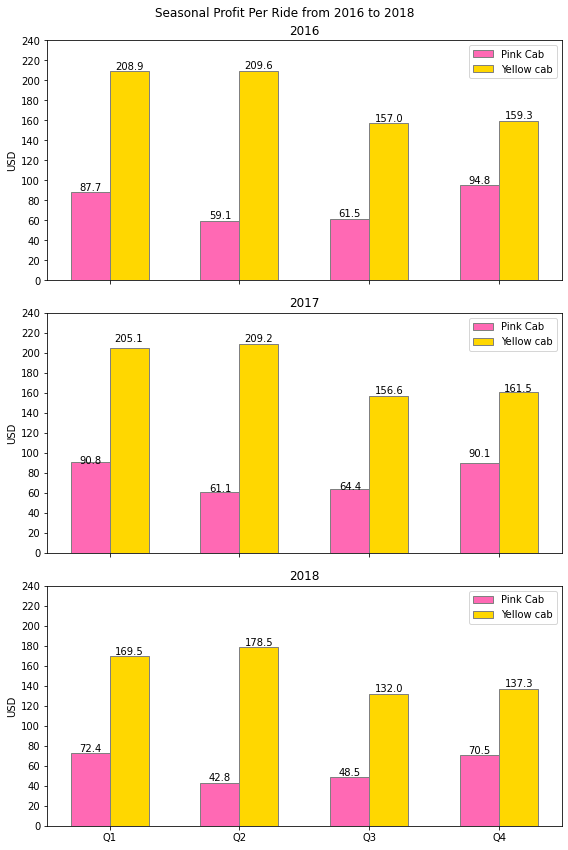

In [339]:
barWidth = 0.3
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]

fig, axs = plt.subplots(3,1, sharex=True, figsize= (8,12))

# fig, axs = plt.subplots(nrows=1,ncols=2, figsize= (8,6))
fig.suptitle('Seasonal Profit Per Ride from 2016 to 2018')

pi_q1 = axs[0].bar(br1, profit_perride[0,0,:4], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
ye_q1 = axs[0].bar(br2, profit_perride[1,0,:4], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[0].bar_label(pi_q1,labels=[str(profit_perride[0,0,i]) for i in range(4)])
axs[0].bar_label(ye_q1,labels=[str(profit_perride[1,0,i]) for i in range(4)])
axs[0].legend(['Pink Cab', 'Yellow cab'])
axs[0].set_title('2016')
axs[0].set_xticks([r + 0.5*barWidth for r in range(4)], ['Q1','Q2','Q3','Q4'])
axs[0].set_yticks(np.arange(0,260,20),[str(i) for i in range(0,260,20)])
axs[0].set_ylabel('USD')

pi_q2 = axs[1].bar(br1, profit_perride[0,1,:4], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
ye_q2 = axs[1].bar(br2, profit_perride[1,1,:4], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[1].bar_label(pi_q1,labels=[str(profit_perride[0,1,i]) for i in range(4)])
axs[1].bar_label(ye_q1,labels=[str(profit_perride[1,1,i]) for i in range(4)])
axs[1].legend(['Pink Cab', 'Yellow cab'])
axs[1].set_title('2017')
axs[1].set_xticks([r + 0.5*barWidth for r in range(4)], ['Q1','Q2','Q3','Q4'])
axs[1].set_yticks(np.arange(0,260,20),[str(i) for i in range(0,260,20)])
axs[1].set_ylabel('USD')

pi_q3 = axs[2].bar(br1, profit_perride[0,2,:4], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
ye_q3 = axs[2].bar(br2, profit_perride[1,2,:4], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[2].bar_label(pi_q3,labels=[str(profit_perride[0,2,i]) for i in range(4)])
axs[2].bar_label(ye_q3,labels=[str(profit_perride[1,2,i]) for i in range(4)])
axs[2].legend(['Pink Cab', 'Yellow cab'])
axs[2].set_title('2018')
axs[2].set_xticks([r + 0.5*barWidth for r in range(4)], ['Q1','Q2','Q3','Q4'])
axs[2].set_yticks(np.arange(0,260,20),[str(i) for i in range(0,260,20)])
axs[2].set_ylabel('USD')

fig.tight_layout()

Text(0, 0.5, 'USD')

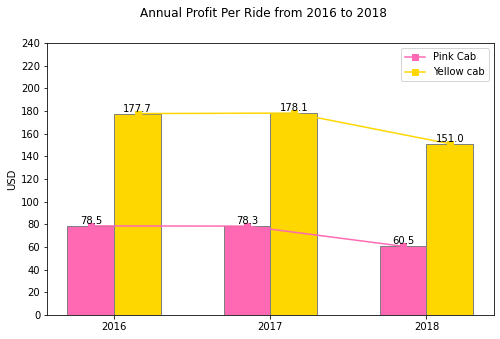

In [154]:
barWidth = 0.3
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]

fig, axs = plt.subplots(1,1, sharex=True, figsize= (8,5))

# fig, axs = plt.subplots(nrows=1,ncols=2, figsize= (8,6))
fig.suptitle('Annual Profit Per Ride from 2016 to 2018')

pi_q1 = axs.bar(br1, profit_perride[0,:,4], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
ye_q1 = axs.bar(br2, profit_perride[1,:,4], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
pi_l1 = axs.plot(br1, profit_perride[0,:,4], color = 'hotpink', marker = 's')
ye_l1 = axs.plot(br2, profit_perride[1,:,4], color = 'gold', marker = 's')
axs.bar_label(pi_q1,labels=[str(profit_perride[0,i,4]) for i in range(3)])
axs.bar_label(ye_q1,labels=[str(profit_perride[1,i,4]) for i in range(3)])
axs.legend(['Pink Cab', 'Yellow cab'])
axs.set_xticks([r + 0.5*barWidth for r in range(3)], ['2016','2017','2018'])
axs.set_yticks(np.arange(0,260,20),[str(i) for i in range(0,260,20)])
axs.set_ylabel('USD')

## portion of total seasonal profits/ total profits over the years

In [240]:
sea_ann_profit_por = np.ma.empty((2, 4))
for i in range(2):
    for sea in range(4):
        sum_ann_profit = sum(ann_profits[i, :]) #(company, year)
        sum_sea_profit = sum(sea_profits[i, :, sea]) #(company, year, season)
        sea_ann_profit_por[i, sea] = sum_sea_profit / sum_ann_profit
        sea_ann_profit_por[i, sea] = round(sea_ann_profit_por[i, sea],2)
        

## portion of seasonal profits of each year: seasonal profit each year / total profit each year

In [79]:
sea_profit_annpor = np.ma.empty((2, 3, 4))
for i in range(2):
    for iyear in range(3):
        for k in range(4):
            sea_profit_annpor[i, iyear, k] = sea_profits[i, iyear, k] / ann_profits[i,iyear]
            sea_profit_annpor[i, iyear, k] = "{:.2f}".format(sea_profit_annpor[i, iyear, k])
            

## plots: annual amount of profit and seasonal portion of profit

Text(0, 0.5, 'Million USD')

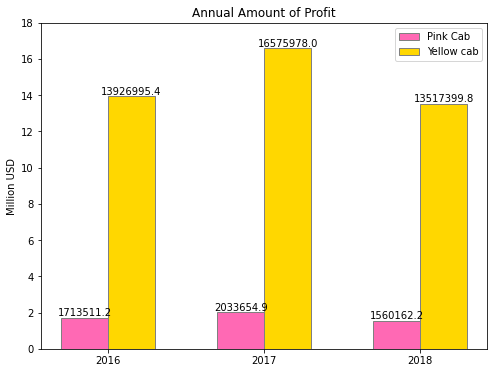

In [341]:
barWidth = 0.3
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
fig, axs = plt.subplots(nrows=1,ncols=1, figsize= (8,6))
# fig.suptitle('Annual and Seasonal Profit Data from 2016 to 2018')
pi_q1 = axs.bar(br1, ann_profits[0], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
ye_q1 = axs.bar(br2, ann_profits[1], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs.bar_label(pi_q1,labels=[str(ann_profits[0,i].round(1)) for i in range(3)])
axs.bar_label(ye_q1,labels=[str(ann_profits[1,i].round(1)) for i in range(3)])
axs.legend(['Pink Cab', 'Yellow cab'])
axs.set_title('Annual Amount of Profit')
axs.set_xticks([r + 0.5*barWidth for r in range(3)], ['2016','2017','2018'])
axs.set_yticks(np.arange(0.0e7,2.0e7,0.2e7))
axs.set_yticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16','18'])
axs.set_ylabel('Million USD')


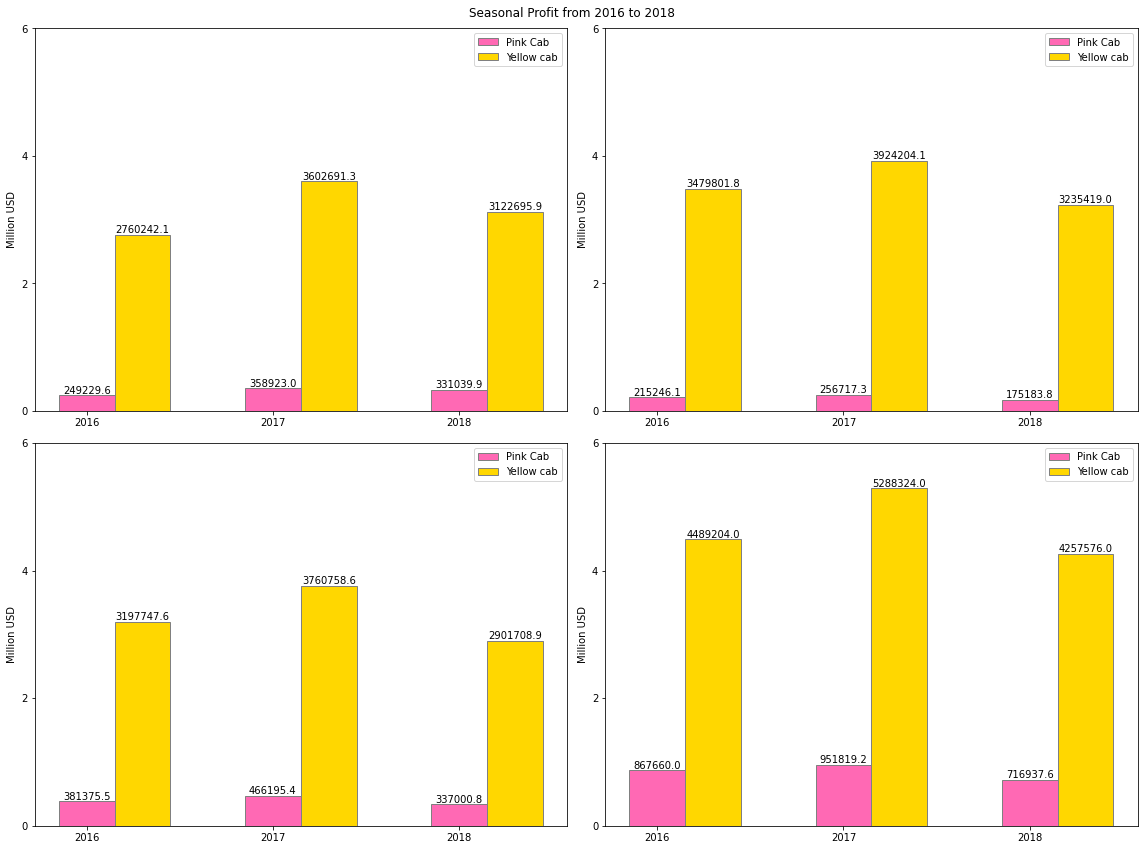

In [343]:

# sea_ann_profit
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
fig, axs = plt.subplots(nrows=2,ncols=2, figsize= (16,12))
fig.suptitle('Seasonal Profit from 2016 to 2018')

pi_sea = axs[0,0].bar(br1, sea_profits[0,:,0], width = barWidth, color = 'hotpink', align='center', label = 'Pink Cab', edgecolor ='grey')
ye_sea = axs[0,0].bar(br2, sea_profits[1,:,0], width = barWidth, color = 'gold', align='center', label = 'Yellow Cab', edgecolor ='grey')
axs[0,0].bar_label(pi_sea,labels=[str(sea_profits[0,i,0].round(1)) for i in range(3)])
axs[0,0].bar_label(ye_sea,labels=[str(sea_profits[1,i,0].round(1)) for i in range(3)])
axs[0,0].legend(['Pink Cab', 'Yellow cab'])
axs[0,0].set_xticks(br1, ['2016','2017','2018'])
axs[0,0].set_yticks(np.arange(0.0e7,0.8e7,0.2e7),['0', '2', '4', '6'])
axs[0,0].set_ylabel('Million USD')

pi_sea = axs[0,1].bar(br1, sea_profits[0,:,1], width = barWidth, color = 'hotpink', align='center', label = 'Pink Cab', edgecolor ='grey')
ye_sea = axs[0,1].bar(br2, sea_profits[1,:,1], width = barWidth, color = 'gold', align='center', label = 'Yellow Cab', edgecolor ='grey')
axs[0,1].bar_label(pi_sea,labels=[str(sea_profits[0,i,1].round(1)) for i in range(3)])
axs[0,1].bar_label(ye_sea,labels=[str(sea_profits[1,i,1].round(1)) for i in range(3)])
axs[0,1].legend(['Pink Cab', 'Yellow cab'])
axs[0,1].set_xticks(br1, ['2016','2017','2018'])
axs[0,1].set_yticks(np.arange(0.0e7,0.8e7,0.2e7),['0', '2', '4', '6'])
axs[0,1].set_ylabel('Million USD')

pi_sea = axs[1,0].bar(br1, sea_profits[0,:,2], width = barWidth, color = 'hotpink', align='center', label = 'Pink Cab', edgecolor ='grey')
ye_sea = axs[1,0].bar(br2, sea_profits[1,:,2], width = barWidth, color = 'gold', align='center', label = 'Yellow Cab', edgecolor ='grey')
axs[1,0].bar_label(pi_sea,labels=[str(sea_profits[0,i,2].round(1)) for i in range(3)])
axs[1,0].bar_label(ye_sea,labels=[str(sea_profits[1,i,2].round(1)) for i in range(3)])
axs[1,0].legend(['Pink Cab', 'Yellow cab'])
axs[1,0].set_xticks(br1, ['2016','2017','2018'])
axs[1,0].set_yticks(np.arange(0.0e7,0.8e7,0.2e7),['0', '2', '4', '6'])
axs[1,0].set_ylabel('Million USD')

pi_sea = axs[1,1].bar(br1, sea_profits[0,:,3], width = barWidth, color = 'hotpink', align='center', label = 'Pink Cab', edgecolor ='grey')
ye_sea = axs[1,1].bar(br2, sea_profits[1,:,3], width = barWidth, color = 'gold', align='center', label = 'Yellow Cab', edgecolor ='grey')
axs[1,1].bar_label(pi_sea,labels=[str(sea_profits[0,i,3].round(1)) for i in range(3)])
axs[1,1].bar_label(ye_sea,labels=[str(sea_profits[1,i,3].round(1)) for i in range(3)])
axs[1,1].legend(['Pink Cab', 'Yellow cab'])
axs[1,1].set_xticks(br1, ['2016','2017','2018'])
axs[1,1].set_yticks(np.arange(0.0e7,0.8e7,0.2e7),['0', '2', '4', '6'])
axs[1,1].set_ylabel('Million USD')
fig.tight_layout()

# prediction of annual profit

In [382]:
period = np.arange(2016, 2019)
br3 = np.arange(2016, 2020)
ann_predict = np.ma.empty((2,2))
for i in range(2):
    ann_predict[i,:] = linregress(period, ann_profits[i])[:2]
y_pi = ann_predict[0,0] * br3 + ann_predict[0,1]
y_ye = ann_predict[1,0] * br3 + ann_predict[1,1]


# plot: prediction of annual profit

Text(0, 0.5, 'Million USD')

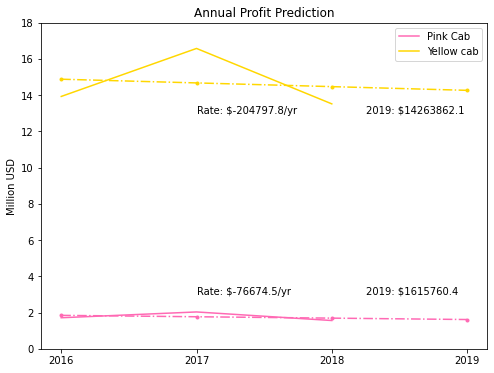

In [384]:
barWidth = 0.3
br1 = np.arange(2016, 2019)
br3 = np.arange(2016, 2020)
fig, axs = plt.subplots(nrows=1,ncols=1, figsize= (8,6))
axs.plot(br1, ann_profits[0], color = 'hotpink')
axs.plot(br1, ann_profits[1], color = 'gold')
axs.legend(['Pink Cab', 'Yellow cab'])
axs.plot(br3, y_pi, '.-.', color = 'hotpink')
axs.plot(br3, y_ye, '.-.', color = 'gold')
plt.annotate('Rate: $' +str(ann_predict[0,0].round(1)) + '/yr', (2017,0.3e7))
plt.annotate('2019: $' +str((ann_predict[0,0]*2019 + ann_predict[0,1]).round(1)), (2018.25,0.3e7))
plt.annotate('Rate: $' +str(ann_predict[1,0].round(1)) + '/yr', (2017,1.3e7))
plt.annotate('2019: $' +str((ann_predict[1,0]*2019 + ann_predict[1,1]).round(1)), (2018.25,1.3e7))
axs.set_title('Annual Profit Prediction')
axs.set_xticks(br3, ['2016', '2017', '2018','2019'])
axs.set_yticks(np.arange(0,2e7, 2e6), ['0', '2', '4', '6', '8', '10', '12', '14', '16','18'])
axs.set_ylabel('Million USD')

# prediction of the seasonal profit

In [378]:
period = np.arange(2016, 2019)
sea_predict = np.ma.empty((2, 4, 2))
for i in range(2):
    for j in range(4):
        sea_predict[i, j, :] = linregress(period, sea_profits[i, :, j])[:2]

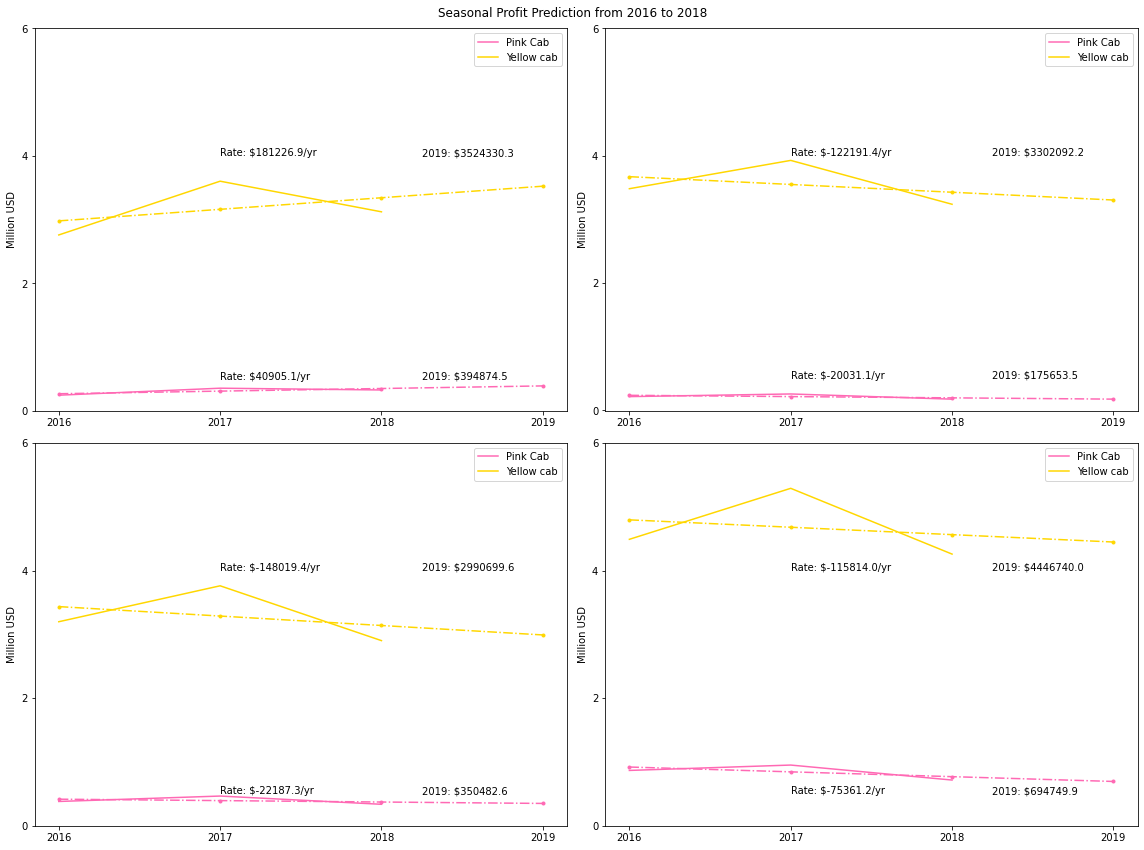

In [385]:

# sea_ann_profit
br1 = np.arange(2016, 2019)
br3 = np.arange(2016, 2020)
# br2 = [x + barWidth for x in br1]
fig, axs = plt.subplots(nrows=2,ncols=2, figsize= (16,12))
fig.suptitle('Seasonal Profit Prediction from 2016 to 2018')

pi_sea = axs[0,0].plot(br1, sea_profits[0,:,0], color = 'hotpink')
ye_sea = axs[0,0].plot(br1, sea_profits[1,:,0], color = 'gold')
axs[0,0].legend(['Pink Cab', 'Yellow cab'])
axs[0,0].plot(br3, sea_predict[0,0,0] *br3 + sea_predict[0,0,1], '.-.', color = 'hotpink')
axs[0,0].plot(br3, sea_predict[1,0,0] *br3 + sea_predict[1,0,1], '.-.', color = 'gold')
axs[0,0].annotate('Rate: $' +str(sea_predict[0,0,0].round(1)) + '/yr', (2017,0.5e6))
axs[0,0].annotate('2019: $' +str((sea_predict[0,0,0]*2019 + sea_predict[0,0,1]).round(1)), (2018.25,0.5e6))
axs[0,0].annotate('Rate: $' +str(sea_predict[1,0,0].round(1)) + '/yr', (2017,4e6))
axs[0,0].annotate('2019: $' +str((sea_predict[1,0,0]*2019 + sea_predict[1,0,1]).round(1)), (2018.25,4e6))
axs[0,0].set_xticks(br3, ['2016','2017','2018','2019'])
axs[0,0].set_yticks(np.arange(0.0e7,0.8e7,0.2e7),['0', '2', '4', '6'])
axs[0,0].set_ylabel('Million USD')

pi_sea = axs[0,1].plot(br1, sea_profits[0,:,1], color = 'hotpink')
ye_sea = axs[0,1].plot(br1, sea_profits[1,:,1], color = 'gold')
axs[0,1].legend(['Pink Cab', 'Yellow cab'])
axs[0,1].plot(br3, sea_predict[0,1,0] *br3 + sea_predict[0,1,1], '.-.', color = 'hotpink')
axs[0,1].plot(br3, sea_predict[1,1,0] *br3 + sea_predict[1,1,1], '.-.', color = 'gold')
axs[0,1].annotate('Rate: $' +str(sea_predict[0,1,0].round(1)) + '/yr', (2017,0.5e6))
axs[0,1].annotate('2019: $' +str((sea_predict[0,1,0]*2019 + sea_predict[0,1,1]).round(1)), (2018.25,0.5e6))
axs[0,1].annotate('Rate: $' +str(sea_predict[1,1,0].round(1)) + '/yr', (2017,4e6))
axs[0,1].annotate('2019: $' +str((sea_predict[1,1,0]*2019 + sea_predict[1,1,1]).round(1)), (2018.25,4e6))
axs[0,1].set_xticks(br3, ['2016','2017','2018','2019'])
axs[0,1].set_yticks(np.arange(0.0e7,0.8e7,0.2e7),['0', '2', '4', '6'])
axs[0,1].set_ylabel('Million USD')

pi_sea = axs[1,0].plot(br1, sea_profits[0,:,2], color = 'hotpink')
ye_sea = axs[1,0].plot(br1, sea_profits[1,:,2], color = 'gold')
axs[1,0].legend(['Pink Cab', 'Yellow cab'])
axs[1,0].plot(br3, sea_predict[0,2,0] *br3 + sea_predict[0,2,1], '.-.', color = 'hotpink')
axs[1,0].plot(br3, sea_predict[1,2,0] *br3 + sea_predict[1,2,1], '.-.', color = 'gold')
axs[1,0].annotate('Rate: $' +str(sea_predict[0,2,0].round(1)) + '/yr', (2017,0.5e6))
axs[1,0].annotate('2019: $' +str((sea_predict[0,2,0]*2019 + sea_predict[0,2,1]).round(1)), (2018.25,0.5e6))
axs[1,0].annotate('Rate: $' +str(sea_predict[1,2,0].round(1)) + '/yr', (2017,4e6))
axs[1,0].annotate('2019: $' +str((sea_predict[1,2,0]*2019 + sea_predict[1,2,1]).round(1)), (2018.25,4e6))
axs[1,0].set_xticks(br3, ['2016','2017','2018','2019'])
axs[1,0].set_yticks(np.arange(0.0e7,0.8e7,0.2e7),['0', '2', '4', '6'])
axs[1,0].set_ylabel('Million USD')

pi_sea = axs[1,1].plot(br1, sea_profits[0,:,3], color = 'hotpink')
ye_sea = axs[1,1].plot(br1, sea_profits[1,:,3],color = 'gold')
axs[1,1].legend(['Pink Cab', 'Yellow cab'])
axs[1,1].plot(br3, sea_predict[0,3,0] *br3 + sea_predict[0,3,1], '.-.', color = 'hotpink')
axs[1,1].plot(br3, sea_predict[1,3,0] *br3 + sea_predict[1,3,1], '.-.', color = 'gold')
axs[1,1].annotate('Rate: $' +str(sea_predict[0,3,0].round(1)) + '/yr', (2017,0.5e6))
axs[1,1].annotate('2019: $' +str((sea_predict[0,3,0]*2019 + sea_predict[0,3,1]).round(1)), (2018.25,0.5e6))
axs[1,1].annotate('Rate: $' +str(sea_predict[1,3,0].round(1)) + '/yr', (2017,4e6))
axs[1,1].annotate('2019: $' +str((sea_predict[1,3,0]*2019 + sea_predict[1,3,1]).round(1)), (2018.25,4e6))
axs[1,1].set_xticks(br3, ['2016','2017','2018','2019'])
axs[1,1].set_yticks(np.arange(0.0e7,0.8e7,0.2e7),['0', '2', '4', '6'])
axs[1,1].set_ylabel('Million USD')
fig.tight_layout()

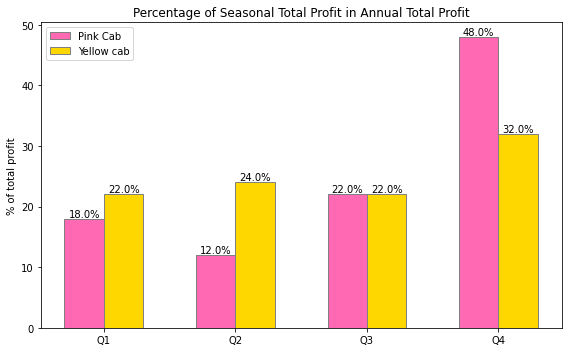

In [376]:
barWidth = 0.3
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
fig, axs = plt.subplots(nrows=1,ncols=1, figsize= (8,5))
# fig.suptitle('Annual and Seasonal Profit Data from 2016 to 2018')
pi_sea = axs.bar(br1, sea_ann_profit_por[0], width = barWidth, color = 'hotpink', align='center', label = 'Pink Cab', edgecolor ='grey')
ye_sea = axs.bar(br2, sea_ann_profit_por[1], width = barWidth, color = 'gold', align='center', label = 'Yellow Cab', edgecolor ='grey')
axs.legend(['Pink Cab', 'Yellow cab'])
axs.set_title('Percentage of Seasonal Total Profit in Annual Total Profit')
axs.set_xticks([x + 0.5*barWidth for x in br1], ['Q1','Q2','Q3','Q4'])
axs.set_yticks(np.arange(0,0.6,0.1),[0, 10, 20, 30, 40, 50])
axs.set_ylabel('% of total profit')

# # Label with label_type the default 'edge'
axs.bar_label(pi_sea,labels=[str(100*sea_ann_profit_por[0][0])+'%',str(100*sea_ann_profit_por[0][1])+'%',str(100*sea_ann_profit_por[0][2])+'%',str(100*sea_ann_profit_por[0][3])+'%'])
axs.bar_label(ye_sea,labels=[str(100*sea_ann_profit_por[1][0])+'%',str(100*sea_ann_profit_por[1][1])+'%',str(100*sea_ann_profit_por[1][2])+'%',str(100*sea_ann_profit_por[1][3])+'%'])
fig.tight_layout()



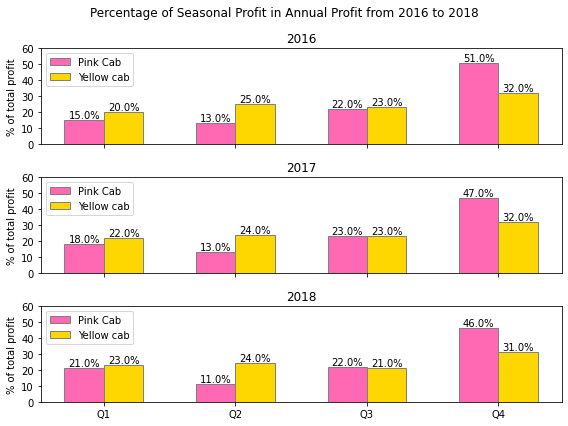

In [ ]:
barWidth = 0.3
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]

fig, axs = plt.subplots(3,1, sharex=True, figsize= (8,6))

# fig, axs = plt.subplots(nrows=1,ncols=2, figsize= (8,6))
fig.suptitle('Percentage of Seasonal Profit in Annual Profit from 2016 to 2018')

pi_q1 = axs[0].bar(br1, sea_profit_annpor[0,0,:], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
ye_q1 = axs[0].bar(br2, sea_profit_annpor[1,0,:], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[0].bar_label(pi_q1,labels=[str(100*sea_profit_annpor[0,0,0])+'%',str(100*sea_profit_annpor[0,0,1])+'%',str(100*sea_profit_annpor[0,0,2])+'%',str(100*sea_profit_annpor[0,0,3])+'%'])
axs[0].bar_label(ye_q1,labels=[str(100*sea_profit_annpor[1,0,0])+'%',str(100*sea_profit_annpor[1,0,1])+'%',str(100*sea_profit_annpor[1,0,2])+'%',str(100*sea_profit_annpor[1,0,3])+'%'])
axs[0].legend(['Pink Cab', 'Yellow cab'])
axs[0].set_title('2016')
axs[0].set_xticks([r + 0.5*barWidth for r in range(4)], ['Q1','Q2','Q3','Q4'])
axs[0].set_yticks(np.arange(0,0.7,0.1),[0, 10, 20, 30, 40, 50, 60])
axs[0].set_ylabel('% of total profit')

pi_q2 = axs[1].bar(br1, sea_profit_annpor[0,1,:], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
ye_q2 = axs[1].bar(br2, sea_profit_annpor[1,1,:], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[1].bar_label(pi_q2,labels=[str(100*sea_profit_annpor[0,1,0])+'%',str(100*sea_profit_annpor[0,1,1])+'%',str(100*sea_profit_annpor[0,1,2])+'%',str(100*sea_profit_annpor[0,1,3])+'%'])
axs[1].bar_label(ye_q2,labels=[str(100*sea_profit_annpor[1,1,0])+'%',str(100*sea_profit_annpor[1,1,1])+'%',str(100*sea_profit_annpor[1,1,2])+'%',str(100*sea_profit_annpor[1,1,3])+'%'])
axs[1].legend(['Pink Cab', 'Yellow cab'])
axs[1].set_title('2017')
axs[1].set_xticks([r + 0.5*barWidth for r in range(4)], ['Q1','Q2','Q3','Q4'])
axs[1].set_yticks(np.arange(0,0.7,0.1),[0, 10, 20, 30, 40, 50, 60])
axs[1].set_ylabel('% of total profit')

pi_q3 = axs[2].bar(br1, sea_profit_annpor[0,2,:], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
ye_q3 = axs[2].bar(br2, sea_profit_annpor[1,2,:], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[2].bar_label(pi_q3,labels=[str(100*sea_profit_annpor[0,2,0])+'%',str(100*sea_profit_annpor[0,2,1])+'%',str(100*sea_profit_annpor[0,2,2])+'%',str(100*sea_profit_annpor[0,2,3])+'%'])
axs[2].bar_label(ye_q3,labels=[str(100*sea_profit_annpor[1,2,0])+'%',str(100*sea_profit_annpor[1,2,1])+'%',str(100*sea_profit_annpor[1,2,2])+'%',str(100*sea_profit_annpor[1,2,3])+'%'])
axs[2].legend(['Pink Cab', 'Yellow cab'])
axs[2].set_title('2018')
axs[2].set_xticks([r + 0.5*barWidth for r in range(4)], ['Q1','Q2','Q3','Q4'])
axs[2].set_yticks(np.arange(0,0.7,0.1),[0, 10, 20, 30, 40, 50, 60])
axs[2].set_ylabel('% of total profit')

fig.tight_layout()


# profit and rides on holiday

In [ ]:
holiday = pd.read_csv('~/dg_intern/DataSets/us_federal_holidays_2011_2020.csv', skiprows = 50, names = ['Date', 'Holiday'], nrows = 30)
# holiday.head()
# holiday.iloc[50:60]
print(holiday)

In [21]:
b = set(holiday['Holiday'])
holiday_list = []
for name in b:
    holiday_list.append(name)
holiday_list.append('Non-holiday')
print(holiday_list)

['Thanksgiving Day', 'Memorial Day', 'Columbus Day', 'Veterans Day', "Washington's Birthday", 'Independence Day', 'Labor Day', 'Birthday of Martin Luther King, Jr.', "New Year's Day", 'Christmas Day', 'Non-holiday']


In [24]:
# 10 holidays in total, to compare, the last one should be averaged over none-holiday values
# (company, 10 holidays + 1 non-holidays)
holiday_rides = np.ma.zeros((2, 3, 11)) 
holiday_profits = np.ma.zeros((2, 3, 11))
days = np.ma.zeros((2, 3, 12, 31))
for i in range(len(cab_trans_customer['Date of Travel'])):
    date = cab_trans_customer['Date of Travel'][i]
    mon = 10* int(date[5]) + int(date[6])
    day = 10* int(date[8]) + int(date[9])
    if cab_trans_customer['Company'][i] == 'Pink Cab':
        cab = 0
    elif cab_trans_customer['Company'][i] == 'Yellow Cab':
        cab = 1
    
    flag = 0
    holiday_label = 0
    for j in range(len(holiday['Date'])):
        holiday_date = holiday['Date'][j]
        holiday_date_list = re.split(r'/', holiday_date) # the date of a certain date
        if (date[:4] == holiday_date_list[2]) and (mon == int(holiday_date_list[0])) and (day == int(holiday_date_list[1])): 
            flag = 1 # if one holiday matches
            holiday_label = j
            
    if flag: 
        holiday_name = holiday['Holiday'][holiday_label] # identify the holiday
        # get the index of holiday in the holiday_list
        holiday_index = holiday_list.index(holiday_name)
        # count
        holiday_rides[cab, int(date[:4]) - 2016, holiday_index] +=1
        holiday_profits[cab, int(date[:4]) - 2016, holiday_index] += cab_trans_customer['Price Charged'][i] - cab_trans_customer['Cost of Trip'][i]
    else:
        days[cab, int(date[:4]) - 2016, mon - 1, day - 1] = 1 
        # holiday_rides[cab, 10] / sum(days)
        holiday_rides[cab,int(date[:4]) - 2016, 10] +=1 # total rides
        holiday_profits[cab, int(date[:4]) - 2016, 10] += cab_trans_customer['Price Charged'][i] - cab_trans_customer['Cost of Trip'][i]
    

In [25]:
sumdays = np.ma.zeros((2, 3))
for i in range(2):
    for j in range(3):
        sumdays[i, j] = np.sum(np.sum(days[i, j, :,:], axis = 0), axis = 0)
print(sumdays)

[[356. 355. 356.]
 [356. 355. 356.]]


In [115]:
mean_holiday_rides = np.ma.empty((2,11))
mean_holiday_profits = np.ma.empty((2,11))
# holiday_rides((2, 3, 11))
# holiday_profits((2, 3, 11))
for cab in range(2):
    mean_holiday_rides[cab, :] = np.mean(holiday_rides[cab, :,:], axis = 0)
    mean_holiday_profits[cab, :] = np.mean(holiday_profits[cab, :,:], axis = 0)

mean_holiday_rides[:,:10] = mean_holiday_rides[:,:10]/3
mean_holiday_profits[:,:10] = mean_holiday_profits[:,:10]/3

mean_holiday_rides[:,10] = mean_holiday_rides[:,10]/1067 # sum(sumdays) = [1067, 1067]
mean_holiday_profits[:,10] = mean_holiday_profits[:,10]/1067
    
for i in range(2):
    for j in range(11):
        mean_holiday_rides[i, j] = round(mean_holiday_rides[i,j], 0)
        mean_holiday_profits[i, j] = round(mean_holiday_profits[i,j], 1)
print('mean_holiday_rides', mean_holiday_rides)
print('mean_holiday_profits',mean_holiday_profits)


mean_holiday_rides [[34.0 12.0 21.0 46.0 5.0 12.0 20.0 7.0 18.0 17.0 26.0]
 [95.0 38.0 54.0 128.0 33.0 38.0 54.0 30.0 50.0 42.0 84.0]]
mean_holiday_profits [[1806.1 230.8 1083.3 4722.0 287.0 392.4 691.3 316.1 1655.5 1491.1 1622.4]
 [10082.7 6623.6 6440.2 23067.2 6155.6 4676.9 5314.9 4844.9 7168.2 5420.5
  13527.7]]


In [27]:
# bubble sort
def bubbleSort(arr):
    n = len(arr)
    index = np.arange(n)
    for i in range(n):
        for j in range(0, n-i-1):
            if arr[j] > arr[j+1] :
                arr[j], arr[j+1] = arr[j+1], arr[j]
                index[j], index[j+1] = index[j+1], index[j]
    return arr, index

# plot: averaged ride per day (holiday/nonholiday)

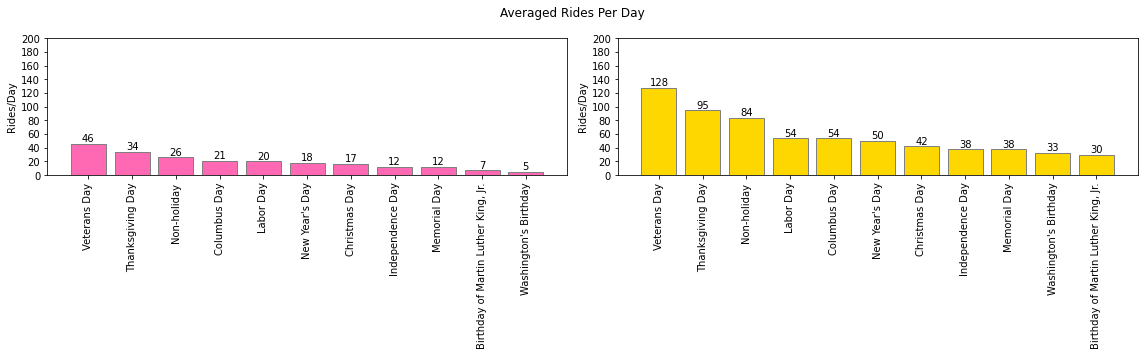

In [116]:
a = mean_holiday_rides[0,:]
holiday_rides_list, holiday_rides_index_list = bubbleSort(a)

barWidth = 0.8
br1 = np.arange(11)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize= (16,5))
fig.suptitle('Averaged Rides Per Day')
pi_cu = ax[0].bar(br1, holiday_rides_list[::-1], barWidth, label = 'Pink Cab', color = 'hotpink',edgecolor ='grey')
ax[0].bar_label(pi_cu,label_type='edge')
ax[0].set_xticks(br1,labels = [holiday_list[i] for i in holiday_rides_index_list[::-1]], rotation = 90)
ax[0].set_yticks(np.arange(0,220,20))
ax[0].set_ylabel('Rides/Day')

b = mean_holiday_rides[1,:]
holiday_rides_list, holiday_rides_index_list = bubbleSort(b)

ye_cu = ax[1].bar(br1, holiday_rides_list[::-1], barWidth, label = 'Yellow Cab', color = 'gold', edgecolor ='grey')
ax[1].bar_label(ye_cu,label_type='edge')
ax[1].set_xticks(br1,labels = [holiday_list[i] for i in holiday_rides_index_list[::-1]], rotation = 90)
ax[1].set_yticks(np.arange(0,220,20))
ax[1].set_ylabel('Rides/Day')

plt.tight_layout()

# plot: averaged profit per day (holiday/nonholiday)

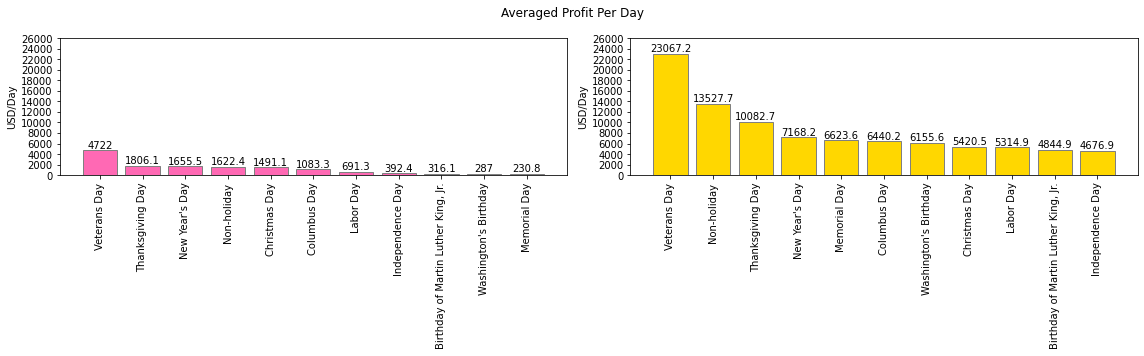

In [117]:
a = mean_holiday_profits[0,:]
holiday_profits_list, holiday_profits_index_list = bubbleSort(a)

barWidth = 0.8
br1 = np.arange(11)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize= (16,5))
fig.suptitle('Averaged Profit Per Day')
pi_cu = ax[0].bar(br1, holiday_profits_list[::-1], barWidth, label = 'Pink Cab', color = 'hotpink',edgecolor ='grey')
ax[0].bar_label(pi_cu,label_type='edge')
ax[0].set_xticks(br1,labels = [holiday_list[i] for i in holiday_profits_index_list[::-1]], rotation = 90)
ax[0].set_yticks(np.arange(0,28000,2000))
ax[0].set_ylabel('USD/Day')

b = mean_holiday_profits[1,:]
holiday_profits_list, holiday_profits_index_list = bubbleSort(b)

ye_cu = ax[1].bar(br1, holiday_profits_list[::-1], barWidth, label = 'Yellow Cab', color = 'gold', edgecolor ='grey')
ax[1].bar_label(ye_cu,label_type='edge')
ax[1].set_xticks(br1,labels = [holiday_list[i] for i in holiday_profits_index_list[::-1]], rotation = 90)
ax[1].set_yticks(np.arange(0,28000,2000))
ax[1].set_ylabel('USD/Day')

plt.tight_layout()

# city-wise customers

In [118]:
def extract_number(number): # number in the format of ' ' with comma and space.
    number = number.strip()
    count = len(number) //4
    t = 0
    sum = 0
    for i, v in enumerate(number):
        if v == ',':
            continue
        else:
            sum += int(v) * (10**(len(number) - 1 - count - t))
            t += 1  
    return sum

check if there's redundent redord

In [119]:
a = set(cab_trans_customer['City'])
city_name_list = [] # collect the list of city where there're customers
for name in city['City']:
    if name in a:
        if name in city_name_list:
            continue
        else:
            city_name_list.append(name)
        continue
    else:
        print('index 14: ' + name + ' is not in the record.')
print('The cities where customers of two cab services cover are listed here: ' + str(city_name_list))

index 14: SAN FRANCISCO CA is not in the record.
The cities where customers of two cab services cover are listed here: ['NEW YORK NY', 'CHICAGO IL', 'LOS ANGELES CA', 'MIAMI FL', 'SILICON VALLEY', 'ORANGE COUNTY', 'SAN DIEGO CA', 'PHOENIX AZ', 'DALLAS TX', 'ATLANTA GA', 'DENVER CO', 'AUSTIN TX', 'SEATTLE WA', 'TUCSON AZ', 'SACRAMENTO CA', 'PITTSBURGH PA', 'WASHINGTON DC', 'NASHVILLE TN', 'BOSTON MA']


In [130]:
# user portion
city_wise_user_por = np.empty((20))
for i, city_name in enumerate(city['City']):
    city_wise_user_por[i] = extract_number(city['Users'][i]) / extract_number(city['Population'][i])
    city_wise_user_por[i] = round(city_wise_user_por[i], 3)

city_wise_user_por.pop(14)

# plot: city_wise_user in total population across cities

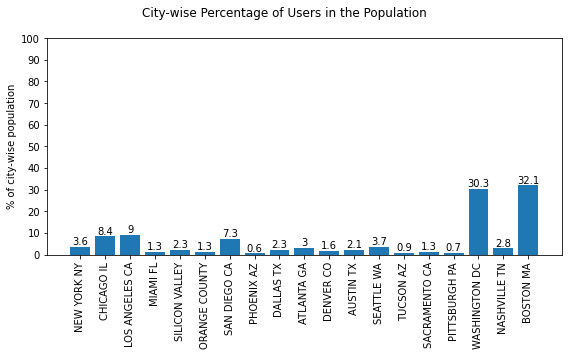

In [133]:
barWidth = 0.8
br1 = np.arange(19)
fig, ax = plt.subplots(nrows=1,ncols=1, figsize= (8,5))
fig.suptitle('City-wise Percentage of Users in the Population')
por = ax.bar(br1, 100*np.delete(city_wise_user_por, 14), barWidth)
ax.bar_label(por,label_type='edge')
ax.set_xticks(np.arange(19),labels = city_name_list, rotation = 90)
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel('% of city-wise population')
# ax.legend(['Yellow Cab', 'Pink cab'])
fig.tight_layout()


In [221]:
city_wise_customer = np.ma.zeros((2, 3, 19))
customer_name_list = [[],[]]
for i in range(len(cab_trans_customer['City'])):
    if cab_trans_customer['Company'][i] == 'Pink Cab':
        cab = 0
    elif cab_trans_customer['Company'][i] == 'Yellow Cab':
        cab = 1
        
    if cab_trans_customer['Customer ID'][i] in customer_name_list[cab]:
        continue
    else:
        index = city_name_list.index(cab_trans_customer['City'][i])
        city_wise_customer[cab,int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, index] += 1
        customer_name_list[cab].append(cab_trans_customer['Customer ID'][i])  
            
                

In [36]:
# check if the number is within the range
for i in range(19):
    if sum(city_wise_customer[0,:,i])+sum(city_wise_customer[1,:,i]) > extract_number(city['Users'][i]):
        print(i, city['City'][i])
        print('number of customers',sum(city_wise_customer[0,:,i])+sum(city_wise_customer[1,:,i]))
        print('number of customers of pink',sum(city_wise_customer[0,:,i]))
        print('number of customers of yellow', sum(city_wise_customer[1,:,i]))
        print('users',city['Users'][i])
    if sum(city_wise_customer[0,:,i])+sum(city_wise_customer[1,:,i]) > extract_number(city['Population'][i]):
        print('error!!')
    

16 PITTSBURGH PA
number of customers 5109.0
number of customers of pink 2109.0
number of customers of yellow 3000.0
users  3,643 


## portion of the customers in different service and city

In [37]:
city_wise_customer_portion = np.ma.zeros((2, 3, 19))
for i in range(2):
    for j in range(3):
        for k in range(19):
            city_wise_customer_portion[i, j, k] = city_wise_customer[i, j, k] / sum(city_wise_customer[:, j, k])
            city_wise_customer_portion[i, j, k] = round(city_wise_customer_portion[i, j, k],3)



# plot: temporal changes of ratio of customers

/var/folders/md/twjjy3517bx9b44nk_x7wtbm0000gn/T/ipykernel_25344/1864257644.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


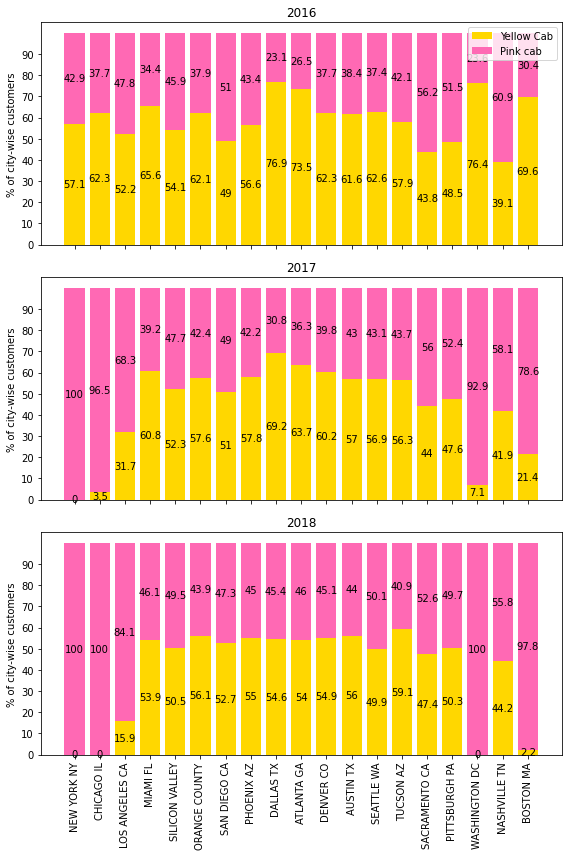

In [362]:
barWidth = 0.8
br1 = np.arange(19)
fig, ax = plt.subplots(nrows=3,ncols=1, figsize= (8,12), sharex = True)
for i in range(3):
       ye_no = ax[i].bar(br1, 100*city_wise_customer_portion[1, i,:], barWidth, label = 'Yellow Cab', color = 'gold')
       pi_no = ax[i].bar(br1, 100*city_wise_customer_portion[0, i,:], barWidth, bottom = 100*city_wise_customer_portion[1, i],
              label='Pink Cab', color = 'hotpink')
       ax[i].bar_label(ye_no,label_type='center')
       ax[i].bar_label(pi_no,label_type='center')
       # ax[i].legend(['Pink Cab', 'Yellow cab'])
       ax[i].set_title(str(2016+i))
       ax[i].set_xticks(np.arange(19),labels = city_name_list, rotation = 90)
       ax[i].set_yticks(np.arange(0,100,10))
       ax[i].set_ylabel('% of city-wise customers')
ax[0].set_xticks(np.arange(19),labels = city_name_list, rotation = 90)
ax[0].legend(['Yellow Cab', 'Pink cab'])
fig.tight_layout()
fig.show()


# plot: number of customers city-wise

In [208]:
city_wise_customer_sum = np.sum(city_wise_customer[1], axis = 0) + np.sum(city_wise_customer[0], axis = 0)
# print(len(city_wise_customer_sum))
city_wise_customer_sum, index_list = bubbleSort(city_wise_customer_sum)
a = np.sum(city_wise_customer[1], axis = 0)
b = np.sum(city_wise_customer[0], axis = 0)

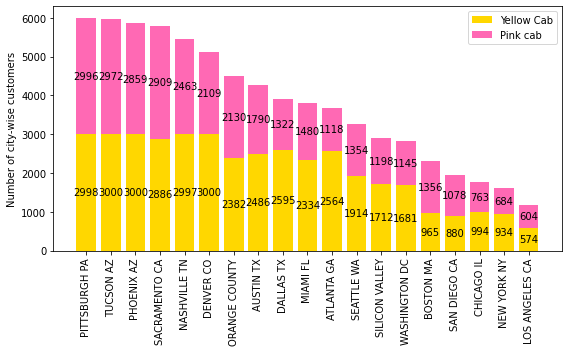

In [171]:
barWidth = 0.8
br1 = np.arange(19)
fig, ax = plt.subplots(nrows=1,ncols=1, figsize= (8,5), sharex = True)

ye_cu = ax.bar(br1, [a[i] for i in index_list[::-1]], barWidth, label = 'Yellow Cab', color = 'gold')
pi_cu = ax.bar(br1, [b[i] for i in index_list[::-1]], barWidth, bottom = [a[i] for i in index_list[::-1]], label='Pink Cab', color = 'hotpink')
ax.bar_label(ye_cu,label_type='center')
ax.bar_label(pi_cu,label_type='center')
# ax[i].legend(['Pink Cab', 'Yellow cab'])
ax.set_xticks(np.arange(19),labels = [city_name_list[i] for i in index_list], rotation = 90)
# ax.set_yticks(np.arange(0,120000,20000), ['0', '20k', '40k', '60k', '80k', '100k'])
ax.set_ylabel('Number of city-wise customers')
ax.legend(['Yellow Cab', 'Pink cab'])
fig.tight_layout()

# customer's retention

defined as the number of customers who used the cab service more than average rides 

In [217]:
a = set(cab_trans_customer['Customer ID']) # to make the names in order
customer_list = []
for id in customer_id['Customer ID']:
    if id in a:
        if id in customer_list:
            continue
        else:
            customer_list.append(id)
        continue

In [218]:
# count the number of each customer id and the cab service they used each year
count = np.ma.zeros((len(customer_list), 2,3))
for i in range(len(cab_trans_customer['Customer ID'])):
    index = customer_list.index(cab_trans_customer['Customer ID'][i])
    if cab_trans_customer['Company'][i] == 'Pink Cab':
        cab = 0
    else:
        cab = 1
    count[index,cab, int(cab_trans_customer['Date of Travel'][i][:4]) - 2016] +=1

## retention compared to the mean

In [219]:
customer_retention = np.ma.empty((2,3))
for i in range(len(customer_list)):
    for j in range(3):
        if count[i, 0, j] >= np.mean(count[:,0,j], axis = 0):
            customer_retention[0,j] += 1
        if count[i, 1, j] >= np.mean(count[:,1,j], axis = 0):
            customer_retention[1,j] += 1 
customer_retention_ratio = np.ma.empty((2,3))
for i in range(2):
    customer_retention_ratio[i,:] = customer_retention[i,:]/len(customer_name_list[i])
for j in range(3):
    print('The average rides taken by the customers in Pink Cab in ' + str(2016+j) + '\n' + str(np.mean(count[:,0,j], axis = 0)))
    print('The average rides taken by the customers in Yellow Cab in ' + str(2016+j) + '\n' +str(np.mean(count[:,1,j], axis = 0)))

In [367]:
period = np.arange(2016, 2019)
prediction_period = np.arange(2016, 2020)
cust_a_predict = np.ma.empty((2,2))
for i in range(2):
    cust_a_predict[0,:] = linregress(period, customer_retention[0])[:2]
    cust_a_predict[1,:] = linregress(period, customer_retention[1])[:2]
y_pi = cust_a_predict[0,0] * prediction_period + cust_a_predict[0,1]
y_ye = cust_a_predict[1,0] * prediction_period + cust_a_predict[1,1]


# plot: customer retention based on average rides

Text(0, 0.5, 'Number of customers')

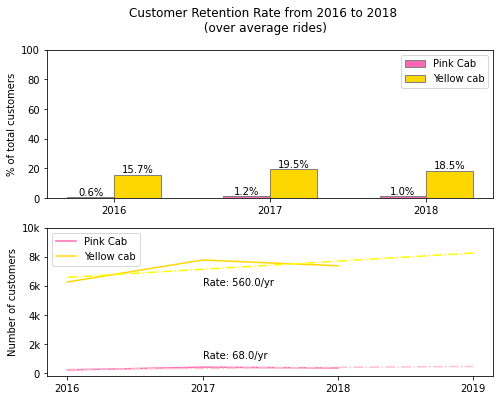

In [371]:
barWidth = 0.3
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = np.arange(2016, 2020)
fig, axs = plt.subplots(nrows=2,ncols=1, figsize= (8,6))
fig.suptitle('Customer Retention Rate from 2016 to 2018\n (over average rides)')

pi_q = axs[0].bar(br1, customer_retention_ratio[0,:], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
ye_q = axs[0].bar(br2, customer_retention_ratio[1,:], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[0].bar_label(pi_q,labels=[str(round(100*customer_retention_ratio[0,0],1))+'%',str(round(100*customer_retention_ratio[0,1],1))+'%',str(round(100*customer_retention_ratio[0,2],1))+'%'])
axs[0].bar_label(ye_q,labels=[str(round(100*customer_retention_ratio[1,0],1))+'%',str(round(100*customer_retention_ratio[1,1],1))+'%',str(round(100*customer_retention_ratio[1,2],1))+'%'])
axs[0].legend(['Pink Cab', 'Yellow cab'])
axs[0].set_xticks([r + 0.5*barWidth for r in range(3)], ['2016','2017','2018'])
axs[0].set_yticks(np.arange(0,1.2,0.2),['0', '20', '40', '60', '80', '100'])
axs[0].set_ylabel('% of total customers')

axs[1].plot(np.arange(2016, 2019), customer_retention[0,:], color = 'hotpink')
axs[1].plot(np.arange(2016, 2019), customer_retention[1,:], color = 'gold')
axs[1].legend(['Pink Cab', 'Yellow cab'])
axs[1].plot(br3, y_pi, '-.', color = 'pink')
axs[1].plot(br3, y_ye, '-.', color = 'yellow')
axs[1].annotate('Rate: ' +str(cust_a_predict[0,0].round(0)) + '/yr', (2017,1e3))
axs[1].annotate('Rate: ' +str(cust_a_predict[1,0].round(0)) + '/yr', (2017,6e3))
axs[1].set_xticks(br3, ['2016','2017','2018','2019'])
axs[1].set_yticks(np.arange(0,12e3, 2e3))
axs[1].set_yticklabels(['0', '2k', '4k', '6k', '8k', '10k'])
axs[1].set_ylabel('Number of customers')

## retention compared to 5

In [373]:
customer_retention = np.ma.empty((2,3))
for i in range(len(customer_list)):
    for j in range(3):
        # print('The average rides taken by the customers in Pink Cab: ' + str(np.mean(count[:,0,j], axis = 0)))
        # print('The average rides taken by the customers in Yellow Cab: ' + str(np.mean(count[:,1,j], axis = 0)))
        if count[i, 0, j] >= 5:
            customer_retention[0,j] += 1 
        if count[i, 1, j] >= 5:
            customer_retention[1,j] += 1 
customer_retention_ratio = np.ma.empty((2,3))
for i in range(2):
    customer_retention_ratio[i,:] = customer_retention[i,:]/len(customer_name_list[i])

In [374]:
period = np.arange(2016, 2019)
cust_a_predict = np.ma.empty((2,2))
for i in range(2):
    cust_a_predict[0,:] = linregress(period, customer_retention[0])[:2]
    cust_a_predict[1,:] = linregress(period, customer_retention[1])[:2]
y_pi = cust_a_predict[0,0] * prediction_period + cust_a_predict[0,1]
y_ye = cust_a_predict[1,0] * prediction_period + cust_a_predict[1,1]


# plot: customer retention based on standard rides

Text(0, 0.5, 'Number of customers')

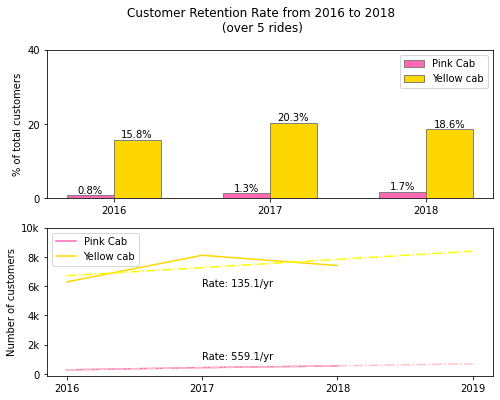

In [375]:
barWidth = 0.3
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
fig, axs = plt.subplots(nrows=2,ncols=1, figsize= (8,6))
fig.suptitle('Customer Retention Rate from 2016 to 2018 \n (over 5 rides) ')

pi_q = axs[0].bar(br1, customer_retention_ratio[0,:], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
ye_q = axs[0].bar(br2, customer_retention_ratio[1,:], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[0].bar_label(pi_q,labels=[str(round(100*customer_retention_ratio[0,0],1))+'%',str(round(100*customer_retention_ratio[0,1],1))+'%',str(round(100*customer_retention_ratio[0,2],1))+'%'])
axs[0].bar_label(ye_q,labels=[str(round(100*customer_retention_ratio[1,0],1))+'%',str(round(100*customer_retention_ratio[1,1],1))+'%',str(round(100*customer_retention_ratio[1,2],1))+'%'])
axs[0].legend(['Pink Cab', 'Yellow cab'])
axs[0].set_xticks([r + 0.5*barWidth for r in range(3)], ['2016','2017','2018'])
axs[0].set_yticks(np.arange(0,0.6,0.2),['0', '20', '40'])
axs[0].set_ylabel('% of total customers')

axs[1].plot(np.arange(2016, 2019), customer_retention[0,:], color = 'hotpink')
axs[1].plot(np.arange(2016, 2019), customer_retention[1,:], color = 'gold')
axs[1].legend(['Pink Cab', 'Yellow cab'])
axs[1].plot(br3, y_pi, '-.', color = 'pink')
axs[1].plot(br3, y_ye, '-.', color = 'yellow')
axs[1].annotate('Rate: ' +str(cust_a_predict[0,0].round(1)) + '/yr', (2017,6e3))
axs[1].annotate('Rate: ' +str(cust_a_predict[1,0].round(1)) + '/yr', (2017,1e3))
axs[1].set_xticks(br3, ['2016','2017','2018','2019'])
axs[1].set_yticks(np.arange(0,12e3, 2e3))
axs[1].set_yticklabels(['0','2k','4k','6k','8k','10k'])
axs[1].set_ylabel('Number of customers')

# temporal changes of customers

# customer trend

In [289]:
customer_sea_list = [[[[],[],[],[]]]*3]*2
daily_customer = np.ma.zeros((2,3,4))

for i, name in enumerate(cab_trans_customer['Company']):
    if name == 'Pink Cab':
        cab = 0
    elif name == 'Yellow Cab':
        cab = 1
        
    mon = 10* int(cab_trans_customer['Date of Travel'][i][5]) + int(cab_trans_customer['Date of Travel'][i][6])
    day = 10* int(cab_trans_customer['Date of Travel'][i][8]) + int(cab_trans_customer['Date of Travel'][i][9])
        
    if (mon-1) < 3:
        sea = 0
    elif (mon-1) > 2 and (mon-1) < 6:
        sea = 1
    elif (mon-1) > 5 and (mon-1) < 9:
        sea = 2
    else:
        sea = 3    
    if cab_trans_customer['Customer ID'][i] in customer_sea_list[cab][int(cab_trans_customer['Date of Travel'][i][:4]) - 2016][sea]:
        continue
    else:
        daily_customer[cab,int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, sea] += 1
        customer_sea_list[cab][int(cab_trans_customer['Date of Travel'][i][:4]) - 2016][sea].append(cab_trans_customer['Customer ID'][i])

        
print(daily_customer)

In [344]:
ann_customer_predict = np.ma.empty((2, 2))
ann_customer = np.ma.empty((2,3))
period = np.arange(2016, 2019)
for i in range(2):
    ann_customer[i,:] = np.sum(daily_customer[i,:,:], axis = 1)
    ann_customer_predict[i,:] = linregress(period,np.sum(daily_customer[i,:,:], axis = 1))[:2]

# build a polynomial regression model for customer data

In [345]:
def polynomial_regression(array):
    period = np.arange(2016, 2019)
    predict_period = np.arange(2016, 2020)
    u = polyfit(period, array, deg=3)
    model_result = u[0] * predict_period**3 + u[1] *predict_period**2 + u[2]*predict_period**1 + u[3]
    return model_result

In [346]:
ann_prediction = np.ma.empty((2, 4))
for i in range(2):
    ann_prediction[i,:] = polynomial_regression(ann_customer[i,:])

/var/folders/md/twjjy3517bx9b44nk_x7wtbm0000gn/T/ipykernel_3300/1042429867.py:3: RankWarning: Polyfit may be poorly conditioned
  ann_prediction[i,:] = polynomial_regression(ann_customer[i,:])
/var/folders/md/twjjy3517bx9b44nk_x7wtbm0000gn/T/ipykernel_3300/1042429867.py:3: RankWarning: Polyfit may be poorly conditioned
  ann_prediction[i,:] = polynomial_regression(ann_customer[i,:])


In [347]:
sea_prediction = np.ma.empty((2,4,4))
for i in range(2):
    for j in range(4):
        sea_prediction[i, j,:] = polynomial_regression(daily_customer[i,:,j])

/var/folders/md/twjjy3517bx9b44nk_x7wtbm0000gn/T/ipykernel_3300/2208444592.py:4: RankWarning: Polyfit may be poorly conditioned
  sea_prediction[i, j,:] = polynomial_regression(daily_customer[i,:,j])
/var/folders/md/twjjy3517bx9b44nk_x7wtbm0000gn/T/ipykernel_3300/2208444592.py:4: RankWarning: Polyfit may be poorly conditioned
  sea_prediction[i, j,:] = polynomial_regression(daily_customer[i,:,j])
/var/folders/md/twjjy3517bx9b44nk_x7wtbm0000gn/T/ipykernel_3300/2208444592.py:4: RankWarning: Polyfit may be poorly conditioned
  sea_prediction[i, j,:] = polynomial_regression(daily_customer[i,:,j])
/var/folders/md/twjjy3517bx9b44nk_x7wtbm0000gn/T/ipykernel_3300/2208444592.py:4: RankWarning: Polyfit may be poorly conditioned
  sea_prediction[i, j,:] = polynomial_regression(daily_customer[i,:,j])
/var/folders/md/twjjy3517bx9b44nk_x7wtbm0000gn/T/ipykernel_3300/2208444592.py:4: RankWarning: Polyfit may be poorly conditioned
  sea_prediction[i, j,:] = polynomial_regression(daily_customer[i,:,j])


# plot: annual customer prediction (polynomial regression analysis)

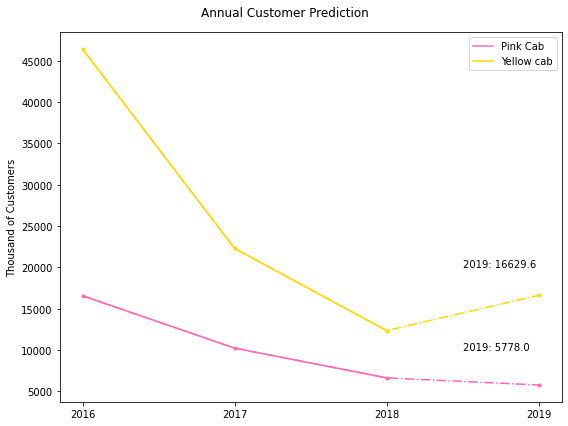

In [358]:

# sea_ann_profit
br1 = np.arange(2016, 2019)
br2 = [x + barWidth for x in br1]
br3 = np.arange(2016, 2020)
fig, axs = plt.subplots(nrows=1,ncols=1, figsize= (8,6))
fig.suptitle('Annual Customer Prediction')

pi_sea = axs.plot(br1, np.sum(daily_customer[0,:,:], axis = 1), color = 'hotpink')
ye_sea = axs.plot(br1, np.sum(daily_customer[1,:,:], axis = 1), color = 'gold')
axs.legend(['Pink Cab', 'Yellow cab'])
axs.plot(br3, ann_prediction[0,:], '.-.', color = 'hotpink')
axs.plot(br3, ann_prediction[1,:], '.-.', color = 'gold')
axs.annotate('2019: ' +str(ann_prediction[0,3].round(1)), (2018.5,10000))
axs.annotate('2019: ' +str(ann_prediction[1,3].round(1)), (2018.5,20000))
axs.set_xticks(br3, ['2016','2017','2018','2019'])
# axs.set_yticks(np.arange(0,18e3,2e3),['0', '2', '4', '6', '8', '10', '12', '14', '16'])
axs.set_ylabel('Thousand of Customers')

fig.tight_layout()

# plot: seasonal customer prediction (polynomial regression analysis)

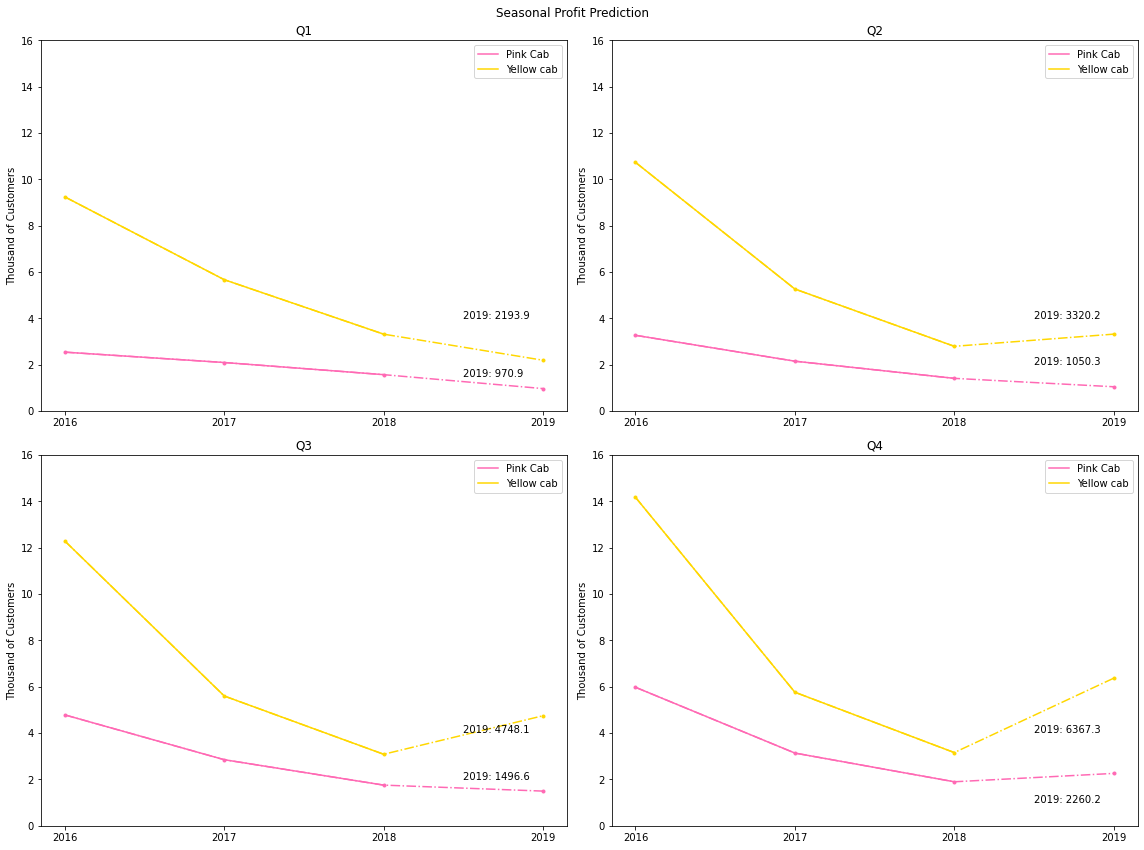

In [363]:

# sea_ann_profit
br1 = np.arange(2016, 2019)
br2 = [x + barWidth for x in br1]
br3 = np.arange(2016, 2020)
fig, axs = plt.subplots(nrows=2,ncols=2, figsize= (16,12))
fig.suptitle('Seasonal Profit Prediction')

pi_sea = axs[0,0].plot(br1, daily_customer[0,:,0], color = 'hotpink')
ye_sea = axs[0,0].plot(br1, daily_customer[1,:,0], color = 'gold')
axs[0,0].legend(['Pink Cab', 'Yellow cab'])
axs[0,0].plot(br3, sea_prediction[0,0,:], '.-.', color = 'hotpink')
axs[0,0].plot(br3, sea_prediction[1,0,:], '.-.', color = 'gold')
axs[0,0].annotate('2019: ' +str(sea_prediction[0,0,3].round(1)), (2018.5,1500))
axs[0,0].annotate('2019: ' +str(sea_prediction[1,0,3].round(1)), (2018.5,4000))
axs[0,0].set_title('Q1')
axs[0,0].set_xticks(br3, ['2016','2017','2018','2019'])
axs[0,0].set_yticks(np.arange(0,18e3,2e3),['0', '2', '4', '6', '8', '10', '12', '14', '16'])
axs[0,0].set_ylabel('Thousand of Customers')

pi_sea = axs[0,1].plot(br1, daily_customer[0,:,1], color = 'hotpink')
ye_sea = axs[0,1].plot(br1, daily_customer[1,:,1], color = 'gold')
axs[0,1].legend(['Pink Cab', 'Yellow cab'])
axs[0,1].plot(br3, sea_prediction[0,1,:], '.-.', color = 'hotpink')
axs[0,1].plot(br3, sea_prediction[1,1,:], '.-.', color = 'gold')
axs[0,1].annotate('2019: ' +str(sea_prediction[0,1,3].round(1)), (2018.5,2000))
axs[0,1].annotate('2019: ' +str(sea_prediction[1,1,3].round(1)), (2018.5,4000))
axs[0,1].set_title('Q2')
axs[0,1].set_xticks(br3, ['2016','2017','2018','2019'])
axs[0,1].set_yticks(np.arange(0,18e3,2e3),['0', '2', '4', '6', '8', '10', '12', '14', '16'])
axs[0,1].set_ylabel('Thousand of Customers')

pi_sea = axs[1,0].plot(br1, daily_customer[0,:,2], color = 'hotpink')
ye_sea = axs[1,0].plot(br1, daily_customer[1,:,2], color = 'gold')
axs[1,0].legend(['Pink Cab', 'Yellow cab'])
axs[1,0].plot(br3, sea_prediction[0,2,:], '.-.', color = 'hotpink')
axs[1,0].plot(br3, sea_prediction[1,2,:], '.-.', color = 'gold')
axs[1,0].annotate('2019: ' +str(sea_prediction[0,2,3].round(1)), (2018.5,2000))
axs[1,0].annotate('2019: ' +str(sea_prediction[1,2,3].round(1)), (2018.5,4000))
axs[1,0].set_title('Q3')
axs[1,0].set_xticks(br3, ['2016','2017','2018','2019'])
axs[1,0].set_yticks(np.arange(0,18e3,2e3),['0', '2', '4', '6', '8', '10', '12', '14', '16'])
axs[1,0].set_ylabel('Thousand of Customers')

pi_sea = axs[1,1].plot(br1, daily_customer[0,:,3], color = 'hotpink')
ye_sea = axs[1,1].plot(br1, daily_customer[1,:,3], color = 'gold')
axs[1,1].legend(['Pink Cab', 'Yellow cab'])
axs[1,1].plot(br3, sea_prediction[0,3,:], '.-.', color = 'hotpink')
axs[1,1].plot(br3, sea_prediction[1,3,:], '.-.', color = 'gold')
axs[1,1].annotate('2019: ' +str(sea_prediction[0,3,3].round(1)), (2018.5,1000))
axs[1,1].annotate('2019: ' +str(sea_prediction[1,3,3].round(1)), (2018.5,4000))
axs[1,1].set_title('Q4')
axs[1,1].set_xticks(br3, ['2016','2017','2018','2019'])
axs[1,1].set_yticks(np.arange(0,18e3,2e3),['0', '2', '4', '6', '8', '10', '12', '14', '16'])
axs[1,1].set_ylabel('Thousand of Customers')
fig.tight_layout()